In [1]:
import os
import re
import json
import numpy as np
import pandas as pd
import networkx as nx

from matplotlib import pyplot as plt

In [2]:
from urllib.parse import urlparse
from urllib.request import urlretrieve

with open('./ufrn.json','r') as f:
    ufrn = json.load(f)


In [3]:
data_directory = './data'
data_org_name = 'ufrn'
for conjunto in ufrn['conjuntoDados']:
    for recurso in conjunto['recursos']:
        if not recurso['formato']: continue
        url = urlparse(recurso['link'])
        filename = url.path.split('/')[-1]
        filepath = os.path.join(data_directory,data_org_name,filename)
        if os.path.exists(filepath): continue
        print('Downloading %s' % filename)
        urlretrieve(url.geturl(),filepath)


In [4]:
db_path = './data/ufrn'

In [5]:
db_resources = [p for p in os.listdir(db_path)]

resources_containing = lambda sw: [os.path.join(db_path,r) for r in db_resources if sw in r and r.endswith('.csv')]
dataframe_containing = lambda sw : pd.concat([pd.read_csv(csv, sep=';',decimal=',') for csv in resources_containing(sw)])

In [6]:
compontentes = dataframe_containing("componentes-curriculares")
compontentes = compontentes[(compontentes['unidade_responsavel'] == 'INSTITUTO METROPOLE DIGITAL') | (compontentes['unidade_responsavel'] == 'DEPARTAMENTO DE INFORMÁTICA E MATEMÁTICA APLICADA')]
compontentes = compontentes[['id_componente','codigo','nome','ch_total']]

In [7]:
turmas = dataframe_containing("turma")
turmas = turmas[turmas['nivel_ensino'] == 'GRADUAÇÃO']
turmas = turmas[turmas['situacao_turma'] == 'CONSOLIDADA']
turmas = turmas[turmas['id_componente_curricular'].isin(compontentes['id_componente'])]
turmas.data_consolidacao = pd.to_datetime(turmas.data_consolidacao)

turmas = turmas[['id_turma','id_componente_curricular','ch_dedicada_periodo','descricao_horario','data_consolidacao']]
turmas['ano'] = [d.year for d in turmas.data_consolidacao]
turmas = turmas.dropna()

In [8]:
matriculas = dataframe_containing("matricula")

matriculas.drop(['unidade','nota','reposicao','faltas_unidade'], axis=1, inplace=True)
matriculas = matriculas[matriculas['id_turma'].isin(turmas['id_turma'])]

matricula_id_descricao = { k:v for k,v in enumerate(matriculas['descricao'].unique()) }
matricula_descricao_id = { v:k for k,v in enumerate(matriculas['descricao'].unique()) }

matriculas['descricao'] = matriculas['descricao'].map(matricula_descricao_id)
matriculas = matriculas[matriculas['media_final'] != 0]
matriculas = matriculas.drop_duplicates()

In [15]:
cursos = dataframe_containing('cursos-ufrn')
cursos = cursos[cursos['id_curso'].isin(matriculas['id_curso'])]
cursos = cursos[['id_curso','nome']]

Text(0.5, 0, 'Nota')

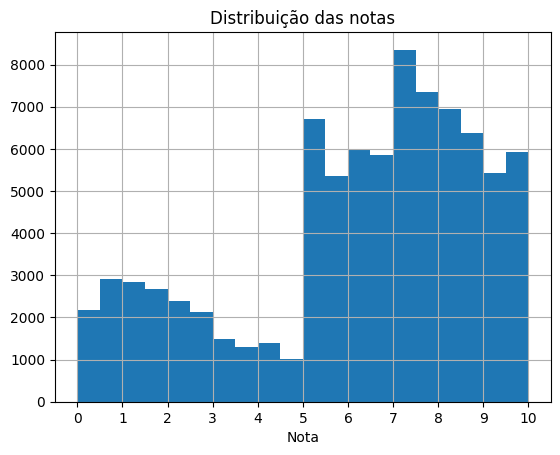

In [18]:
plt.hist(matriculas.media_final,bins=np.arange(0,10.1,.5));
plt.xticks(np.arange(0,10.5,1))
plt.grid(True)
plt.title('Distribuição das notas')
plt.xlabel('Nota')

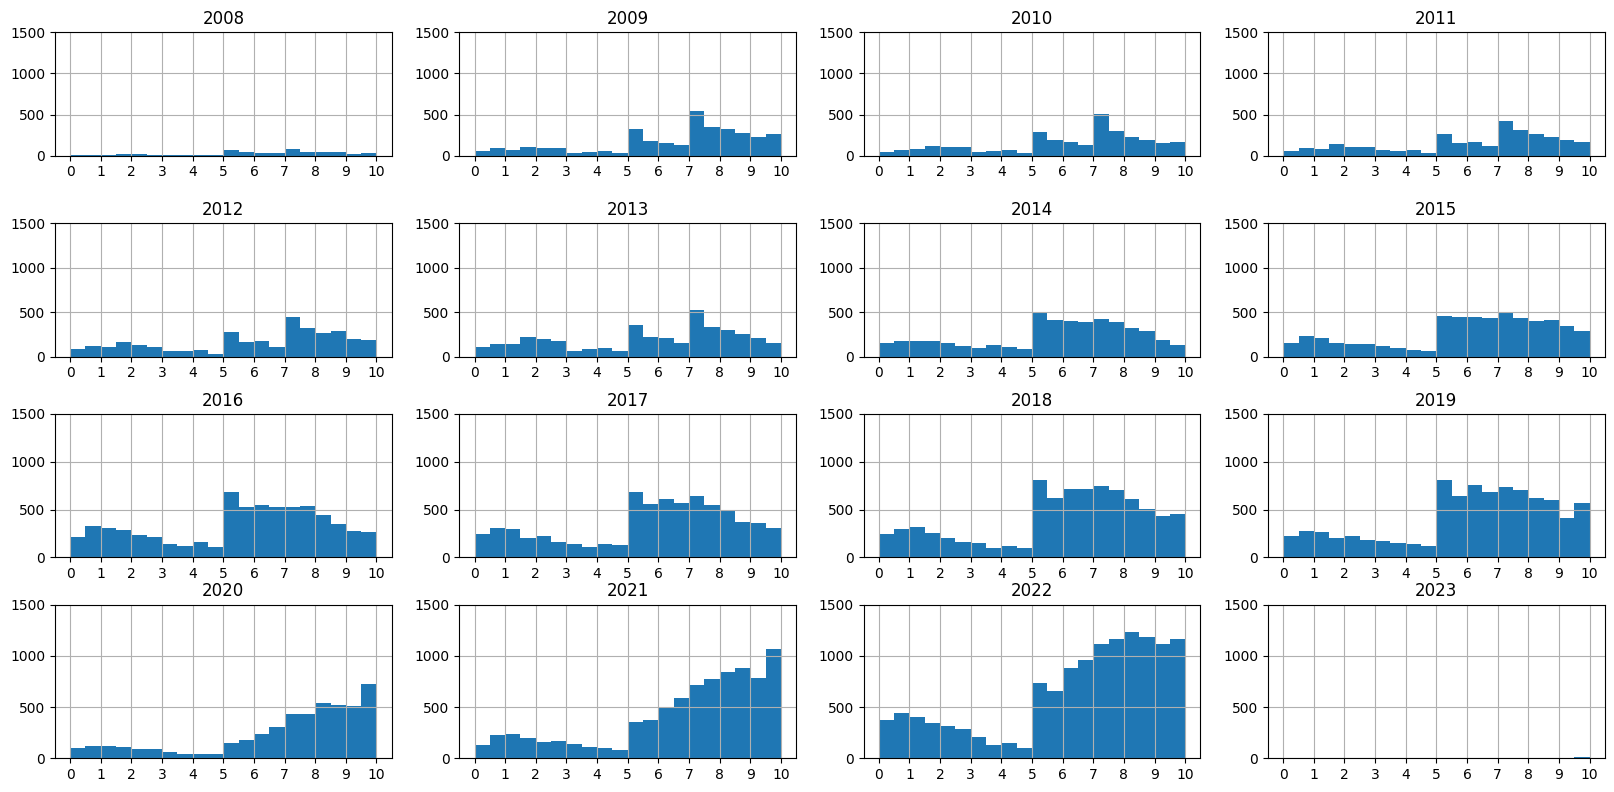

In [19]:
plt.subplots(4,4,figsize=(20,10))
c = 0
for g,gg in turmas.groupby('ano'):
    c+=1
    ax = plt.subplot(4,4,c)
    plt.hist(matriculas[matriculas['id_turma'].isin(gg.id_turma)].media_final,bins=np.arange(0,10.5,.5));
    plt.title(int(g))
    plt.ylim(0,1500)
    plt.xticks(np.arange(0,10.5,1))
    plt.grid(True)
    pos = ax.get_position()
    pos.y1 = pos.y1*.95
    ax.set_position(pos)
    
    

In [20]:
df = matriculas.merge(turmas, on='id_turma', how='right')
df.rename(columns={'id_componente_curricular':'id_componente'}, inplace=True)
df = df.merge(compontentes, on='id_componente', how='left')
df = df.dropna()
df = df.drop_duplicates()
df['ano'] = df['ano'].astype(int)
df['descricao_horario'] = [' '.join(re.findall('[2-7]+[MTN][1-6]+',h)) for h in df['descricao_horario']]

In [23]:
df.sample(4).T

,13295,66589,26405,95530
id_turma,1233661,57628452,1200764,57677903
discente,e2f6cedf3e234ec1aff642a1e4fd3f9a,55422ff94179b9d146b1e66c3b6ace5a,947a95b130e8847eab831a0528fd4404,728899ab75d1fd537f636857a8c48203
id_curso,2000013.0,92127264.0,2000013.0,92127264.0
media_final,2.1,5.0,7.8,2.3
numero_total_faltas,18.0,0.0,0.0,44.0
descricao,4.0,11.0,0.0,4.0
id_componente,2054912,66438,52657,55023
ch_dedicada_periodo,60,30,45,60
descricao_horario,35T12,3N34,6M12,35T34
data_consolidacao,2014-12-12 20:53:18.836000,2018-12-22 01:01:09.167000,2013-06-29 13:49:20.517000,2021-09-14 10:54:47.767000


In [31]:
from itertools import product

In [32]:
graphs_by_year = {}
for ano,df_ano in df.groupby(['ano']):
    Graph1 = nx.Graph()
    for codigo,disciplina in df_ano.groupby('codigo'):
        media = disciplina['media_final'].mean()
        mediana = disciplina['media_final'].median()
        Graph1.add_node(codigo, nome=disciplina['nome'].iloc[0], media=media, mediana=mediana)

    for d,discente in df_ano.groupby('discente'):
        A = discente[['codigo','media_final']].values
        for a,b in product(A,A):
            Graph1.add_edge(a[0],b[0],mean=(a[1]+b[1])/2)
    
    graphs_by_year[ano[0]] = Graph1

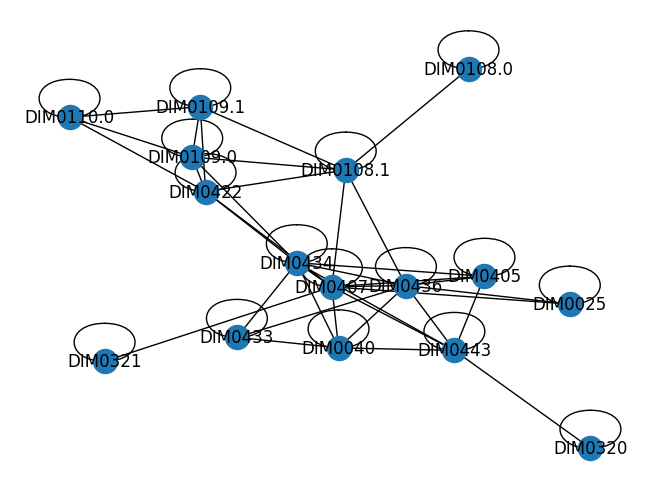

In [33]:
nx.draw(graphs_by_year[2008],with_labels=True)

In [34]:
from pyvis.network import Network

In [35]:
nt = Network('100%', '500px',notebook=True,cdn_resources='in_line')
# populates the nodes and edges data structures
nt.from_nx(graphs_by_year[2009])
nt.barnes_hut()

nt.show_buttons(filter_=['physics'])
nt.show('nx.html')

nx.html


In [20]:
graphs_by_year[2009].nodes(data=True)

NodeDataView({'DIM0021': {'nome': 'SISTEMAS DE INFORMACOES', 'media': 5.74, 'mediana': 5.1, 'size': 10}, 'DIM0025': {'nome': 'RELATORIO DE GRADUACAO', 'media': 8.674999999999999, 'mediana': 8.9, 'size': 10}, 'DIM0040': {'nome': 'CALCULO NUMERICO', 'media': 6.679591836734694, 'mediana': 7.1, 'size': 10}, 'DIM0042': {'nome': 'INTRODUCAO A PROGRAMACAO LINEAR', 'media': 7.514285714285715, 'mediana': 7.1, 'size': 10}, 'DIM0084': {'nome': 'PROGRAMACAO ORIENTADA PARA OBJETOS', 'media': 3.65, 'mediana': 3.65, 'size': 10}, 'DIM0096': {'nome': 'TOPICOS ESPECIAIS EM COMPUTACAO VII', 'media': 7.534999999999999, 'mediana': 7.75, 'size': 10}, 'DIM0098': {'nome': 'TOPICOS ESPECIAIS EM COMPUTACAO IX', 'media': 8.366666666666667, 'mediana': 8.1, 'size': 10}, 'DIM0099': {'nome': 'TOPICOS ESPECIAIS EM COMPUTACAO X', 'media': 8.475, 'mediana': 8.7, 'size': 10}, 'DIM0103': {'nome': 'INTRODUCAO A INFORMATICA', 'media': 7.522506393861893, 'mediana': 7.7, 'size': 10}, 'DIM0104': {'nome': 'SOFTWARES APLICATIVO

In [21]:
graphs_by_year[2009].edges(data=True)

EdgeDataView([('DIM0021', 'DIM0107', {'mean': 8.0, 'width': 1}), ('DIM0021', 'DIM0430', {'mean': 5.0, 'width': 1}), ('DIM0021', 'DIM0437', {'mean': 5.9, 'width': 1}), ('DIM0021', 'DIM0104', {'mean': 6.0, 'width': 1}), ('DIM0021', 'DIM0440', {'mean': 5.05, 'width': 1}), ('DIM0021', 'DIM0442', {'mean': 5.65, 'width': 1}), ('DIM0021', 'DIM0021', {'mean': 5.1, 'width': 1}), ('DIM0021', 'DIM0084', {'mean': 2.65, 'width': 1}), ('DIM0021', 'DIM0310', {'mean': 5.1, 'width': 1}), ('DIM0021', 'DIM0406', {'mean': 6.05, 'width': 1}), ('DIM0021', 'DIM0435', {'mean': 2.8, 'width': 1}), ('DIM0025', 'DIM0406', {'mean': 8.1, 'width': 1}), ('DIM0025', 'DIM0025', {'mean': 9.0, 'width': 1}), ('DIM0025', 'DIM0434', {'mean': 8.0, 'width': 1}), ('DIM0025', 'DIM0420', {'mean': 9.0, 'width': 1}), ('DIM0025', 'DIM0332', {'mean': 8.25, 'width': 1}), ('DIM0040', 'DIM0040', {'mean': 7.9, 'width': 1}), ('DIM0040', 'DIM0320', {'mean': 6.8, 'width': 1}), ('DIM0040', 'DIM0321', {'mean': 8.2, 'width': 1}), ('DIM0040', 